<a href="https://colab.research.google.com/github/DaronDraas/Pyspark/blob/master/matches.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.2-py2.py3-none-any.whl size=317812365 sha256=0eb5bcd29c12acf56cf0118807754d901b86bfb5769077fe8523a9f57ae35137
  Stored in directory: /root/.cache/pip/wheels/34/34/bd/03944534c44b677cd5859f248090daa9fb27b3c8f8e5f49574
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Football_date").getOrCreate()

spark.active()

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
path = '/content/drive/MyDrive/Pyspark_football/matches.csv'

Mounted at /content/drive/


In [ ]:
df = spark.read.csv(path, header=True, inferSchema=True)
#df = spark.read.option("encoding", "ISO-8859-1").csv(path, header=True, sep=";", inferSchema=True )
df.printSchema()
df.show()

root
 |-- Date: string (nullable = true)
 |-- HT: string (nullable = true)
 |-- AT: string (nullable = true)
 |-- HS: integer (nullable = true)
 |-- AS: integer (nullable = true)

+---------+--------------------+--------------------+---+---+
|     Date|                  HT|                  AT| HS| AS|
+---------+--------------------+--------------------+---+---+
|21/6/2008|           La Serena|      Audax Italiano|  1|  1|
|21/6/2008|      Unión Española|           Melipilla|  1|  0|
|22/6/2008|           O'Higgins|Universidad de Co...|  3|  3|
|22/6/2008|         Antofagasta|           Palestino|  0|  3|
|22/6/2008|          Huachipato|            Cobreloa|  1|  2|
|22/6/2008|            Ñublense|             Rangers|  2|  2|
|22/6/2008|    Santiago Morning|Universidad Catolica|  1|  0|
| 9/7/2008|             Everton|            Cobresal|  2|  0|
|16/7/2008|           Colo Colo|              Osorno|  4|  1|
|28/6/2008|              Osorno|          Huachipato|  3|  1|
|28/6/2008|Uni

In [ ]:
from pyspark.sql.functions import col, column, when , to_date, date_format, year, sum as spark_sum
df_dates = df.withColumn("Fecha",to_date(col("Date"), "dd/MM/yyyy"))
df_dates_formatted = df_dates.withColumn("Fecha_formateada", date_format(col("Fecha"), "dd/MM/yyyy"))
df_dates_formatted = df_dates_formatted.withColumn("Annio", year(col("Fecha")))
df_final = df_dates_formatted.drop("Date", "Fecha")
column_order = ["Fecha_formateada", "Annio"] + [col for col in df_final.columns if col not in  ["Fecha_formateada", "Annio"]]
df_final_reordered = df_final.select(column_order)
df_final_reordered.show()

+----------------+-----+--------------------+--------------------+---+---+
|Fecha_formateada|Annio|                  HT|                  AT| HS| AS|
+----------------+-----+--------------------+--------------------+---+---+
|      21/06/2008| 2008|           La Serena|      Audax Italiano|  1|  1|
|      21/06/2008| 2008|      Unión Española|           Melipilla|  1|  0|
|      22/06/2008| 2008|           O'Higgins|Universidad de Co...|  3|  3|
|      22/06/2008| 2008|         Antofagasta|           Palestino|  0|  3|
|      22/06/2008| 2008|          Huachipato|            Cobreloa|  1|  2|
|      22/06/2008| 2008|            Ñublense|             Rangers|  2|  2|
|      22/06/2008| 2008|    Santiago Morning|Universidad Catolica|  1|  0|
|      09/07/2008| 2008|             Everton|            Cobresal|  2|  0|
|      16/07/2008| 2008|           Colo Colo|              Osorno|  4|  1|
|      28/06/2008| 2008|              Osorno|          Huachipato|  3|  1|
|      28/06/2008| 2008|U

In [ ]:
df_puntos = df_final_reordered.withColumn("Puntos_local", when(col("HS") > col("AS"), 3).when(col("HS") == col("AS"), 1).otherwise(0)
).withColumn("Puntos_visitante", when(col("HS") < col("AS"), 3).when(col("HS") == col("AS"), 1).otherwise(0))

df_puntos_ht = df_puntos.select(col("Annio"), col("HT").alias("Equipo"), col("Puntos_local").alias("Puntos"))
df_puntos_at = df_puntos.select(col("Annio"), col("AT").alias("Equipo"), col("Puntos_Visitante").alias("Puntos"))

df_points = df_puntos_ht.union(df_puntos_at)

df_posiciones = df_points.groupBy("Annio", "Equipo").agg(
    spark_sum("Puntos").alias("Total_Puntaje"))

df_posiciones = df_posiciones.orderBy(col("Annio").desc(), col("Total_Puntaje").desc())
df_posiciones.show()

+-----+--------------------+-------------+
|Annio|              Equipo|Total_Puntaje|
+-----+--------------------+-------------+
| 2021|           Colo Colo|           30|
| 2021|Universidad Catolica|           28|
| 2021|Universidad de Chile|           27|
| 2021|           O'Higgins|           27|
| 2021|            Cobresal|           25|
| 2021|      Audax Italiano|           25|
| 2021|           Palestino|           23|
| 2021|        Union Calera|           23|
| 2021|           La Serena|           20|
| 2021|             Everton|           20|
| 2021|      Unión Española|           18|
| 2021|          Huachipato|           18|
| 2021|         Antofagasta|           16|
| 2021|              Curicó|           15|
| 2021|            Ñublense|           13|
| 2021|           Wanderers|           12|
| 2021|           Melipilla|           11|
| 2021|             Iquique|           11|
| 2021|Universidad de Co...|           10|
| 2021|            Coquimbo|            9|
+-----+----

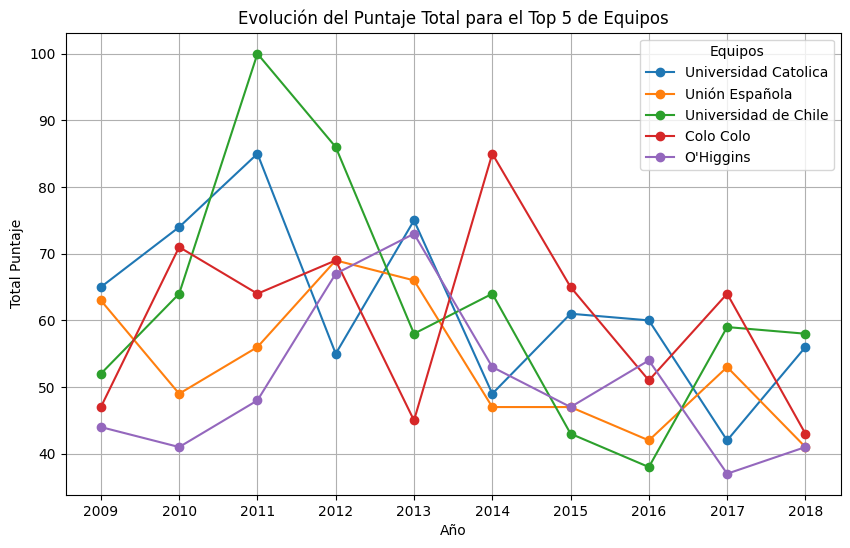

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Obtener el Top 5 de equipos
#top_5_equipos = df_posiciones.groupBy("Equipo").agg(spark_sum("Total_Puntaje").alias("Suma_Total")).orderBy(col("Suma_Total").desc()).limit(5)
# Filtrar los años 2021, 2020, 2019 y 2008
df_posiciones_filtrado = df_posiciones.filter(~col("Annio").isin([2021, 2008, 2019, 2020]))
top_5_equipos = df_posiciones_filtrado.groupBy("Equipo").agg(spark_sum("Total_Puntaje").alias("Suma_Total")).orderBy(col("Suma_Total").desc()).limit(5)

# Filtrar el DataFrame original para mantener solo los equipos del Top 5
df_top5_posiciones = df_posiciones_filtrado.join(top_5_equipos, "Equipo")

# Convertir a Pandas
df_top5_pandas = df_top5_posiciones.toPandas()

# Ordenar por año
df_top5_pandas = df_top5_pandas.sort_values(by=["Annio", "Total_Puntaje"], ascending=[True, False])

# Crear el gráfico de líneas
plt.figure(figsize=(10, 6))

# Graficar una línea para cada equipo
for equipo in df_top5_pandas['Equipo'].unique():
    equipo_data = df_top5_pandas[df_top5_pandas['Equipo'] == equipo]
    plt.plot(equipo_data['Annio'], equipo_data['Total_Puntaje'], marker='o', label=equipo)

# Etiquetas y título del gráfico
plt.xlabel('Año')
plt.ylabel('Total Puntaje')
plt.title('Evolución del Puntaje Total para el Top 5 de Equipos')
plt.legend(title='Equipos')
plt.xticks(df_top5_pandas['Annio'].unique())
plt.grid(True)
plt.show()
